In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


In [2]:
with open('dataset_labeled.json', 'r') as f:
    dataset = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(dataset)

# Filter only labeled entries
df_labeled = df[df['ground_truth'].notna()].copy()

print(f"Total entries: {len(df)}")
print(f"Labeled entries: {len(df_labeled)}")
print(f"\nDataset shape: {df_labeled.shape}")
print(f"\nColumns: {df_labeled.columns.tolist()}")

# Show first few rows
df_labeled.head()

Total entries: 89
Labeled entries: 89

Dataset shape: (89, 11)

Columns: ['event_id', 'event_kind', 'src_ip', 'timestamp', 'lm_confidence', 'severity', 'category', 'recommended_action', 'justification', 'ground_truth', 'notes']


,event_id,event_kind,src_ip,timestamp,lm_confidence,severity,category,recommended_action,justification,ground_truth,notes
0,evt-3611f9ae,port_scan,192.168.1.3,2025-12-23T00:09:21.789022,0.7,Medium,port_scan,monitor,"The event is a port scan, which could be a pre...",1,Auto-labeled: Port scan detected
1,evt-071de8f5,port_scan,192.168.1.3,2025-12-23T00:09:30.723988,0.7,Medium,port_scan,monitor,"The event is a port scan, which could be indic...",1,Auto-labeled: Port scan detected
2,evt-c4817588,port_scan,192.168.1.3,2025-12-23T00:09:40.721355,0.7,Medium,port_scan,monitor,"The event is a port scan, which could be an in...",1,Auto-labeled: Port scan detected
3,evt-0101e498,port_scan,192.168.1.3,2025-12-23T00:09:50.564763,0.7,Medium,port_scan,monitor,"The event is a port scan, which could be indic...",1,Auto-labeled: Port scan detected
4,evt-3479b7d7,port_scan,192.168.1.3,2025-12-23T00:10:00.391176,0.7,Medium,port_scan,monitor,"The event is a port scan, which may indicate a...",1,Auto-labeled: Port scan detected


In [3]:
# Basic statistics
print("="*80)
print("DATASET OVERVIEW")
print("="*80)

# Label distribution
print("\n1. Label Distribution:")
print(df_labeled['ground_truth'].value_counts())
print(f"\nTrue Positive rate: {df_labeled['ground_truth'].mean():.2%}")

# Event types
print("\n2. Event Types:")
print(df_labeled['event_kind'].value_counts())

# Severity distribution
print("\n3. Severity Distribution:")
print(df_labeled['severity'].value_counts())

# Confidence statistics
print("\n4. Confidence Statistics:")
print(df_labeled['lm_confidence'].describe())

DATASET OVERVIEW

1. Label Distribution:
ground_truth
1    57
0    32
Name: count, dtype: int64

True Positive rate: 64.04%

2. Event Types:
event_kind
ssh_failed    46
web_fuzz      32
port_scan     11
Name: count, dtype: int64

3. Severity Distribution:
severity
Medium    89
Name: count, dtype: int64

4. Confidence Statistics:
count    89.000000
mean      0.511236
std       0.046315
min       0.500000
25%       0.500000
50%       0.500000
75%       0.500000
max       0.700000
Name: lm_confidence, dtype: float64


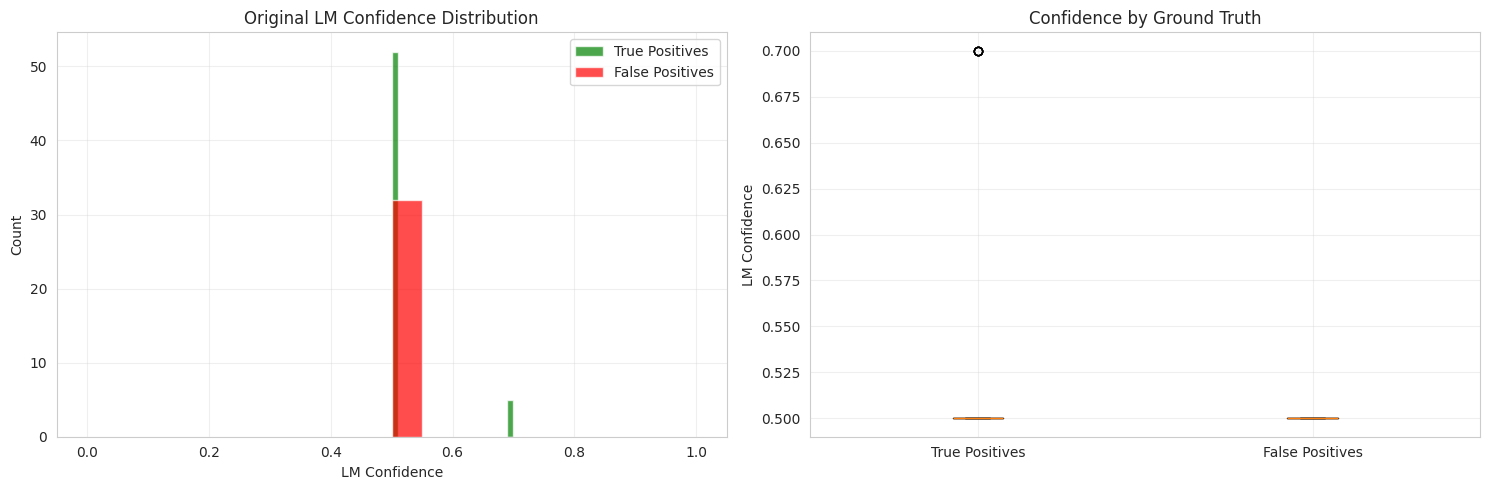

✅ Confidence distribution plotted


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df_labeled[df_labeled['ground_truth'] == 1]['lm_confidence'], 
             bins=20, alpha=0.7, label='True Positives', color='green')
axes[0].hist(df_labeled[df_labeled['ground_truth'] == 0]['lm_confidence'], 
             bins=20, alpha=0.7, label='False Positives', color='red')
axes[0].set_xlabel('LM Confidence')
axes[0].set_ylabel('Count')
axes[0].set_title('Original LM Confidence Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by ground truth
axes[1].boxplot([df_labeled[df_labeled['ground_truth'] == 1]['lm_confidence'],
                 df_labeled[df_labeled['ground_truth'] == 0]['lm_confidence']],
                labels=['True Positives', 'False Positives'])
axes[1].set_ylabel('LM Confidence')
axes[1].set_title('Confidence by Ground Truth')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confidence distribution plotted")

Confidence Statistics by Event Type and Ground Truth:
                             mean       std  count
event_kind ground_truth                           
port_scan  1             0.590909  0.104447     11
ssh_failed 1             0.500000  0.000000     46
web_fuzz   0             0.500000  0.000000     32


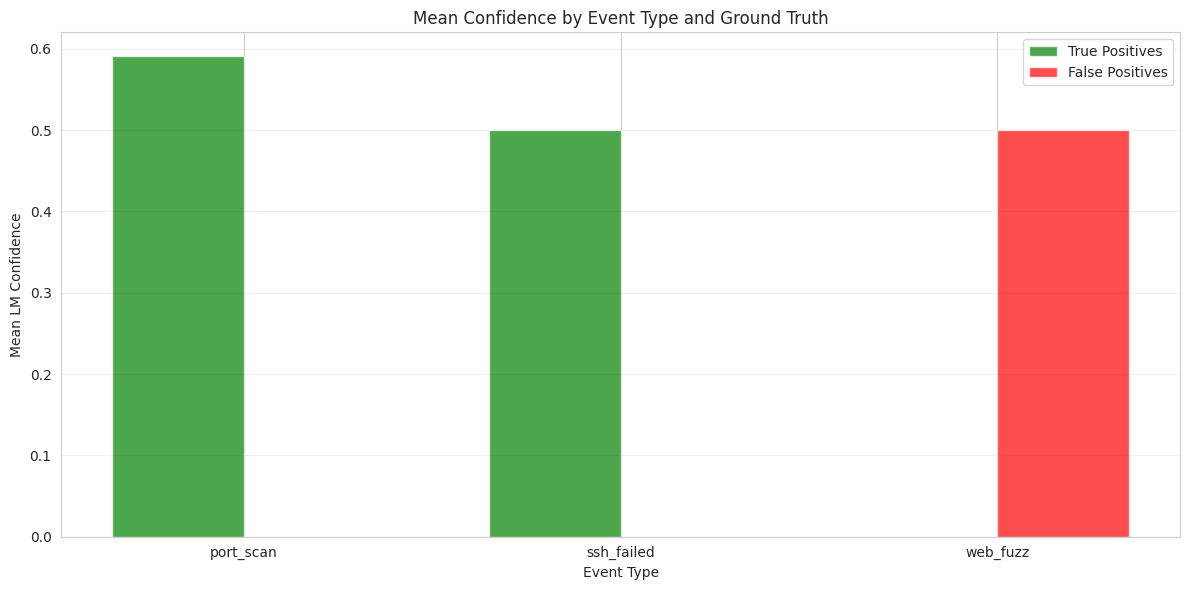

In [5]:
grouped = df_labeled.groupby(['event_kind', 'ground_truth'])['lm_confidence'].agg(['mean', 'std', 'count'])
print("Confidence Statistics by Event Type and Ground Truth:")
print(grouped)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

event_types = df_labeled['event_kind'].unique()
x = np.arange(len(event_types))
width = 0.35

tp_means = [df_labeled[(df_labeled['event_kind'] == et) & (df_labeled['ground_truth'] == 1)]['lm_confidence'].mean() 
            for et in event_types]
fp_means = [df_labeled[(df_labeled['event_kind'] == et) & (df_labeled['ground_truth'] == 0)]['lm_confidence'].mean() 
            for et in event_types]

ax.bar(x - width/2, tp_means, width, label='True Positives', color='green', alpha=0.7)
ax.bar(x + width/2, fp_means, width, label='False Positives', color='red', alpha=0.7)

ax.set_xlabel('Event Type')
ax.set_ylabel('Mean LM Confidence')
ax.set_title('Mean Confidence by Event Type and Ground Truth')
ax.set_xticks(x)
ax.set_xticklabels(event_types)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('confidence_by_event_type.png', dpi=300, bbox_inches='tight')
plt.show()

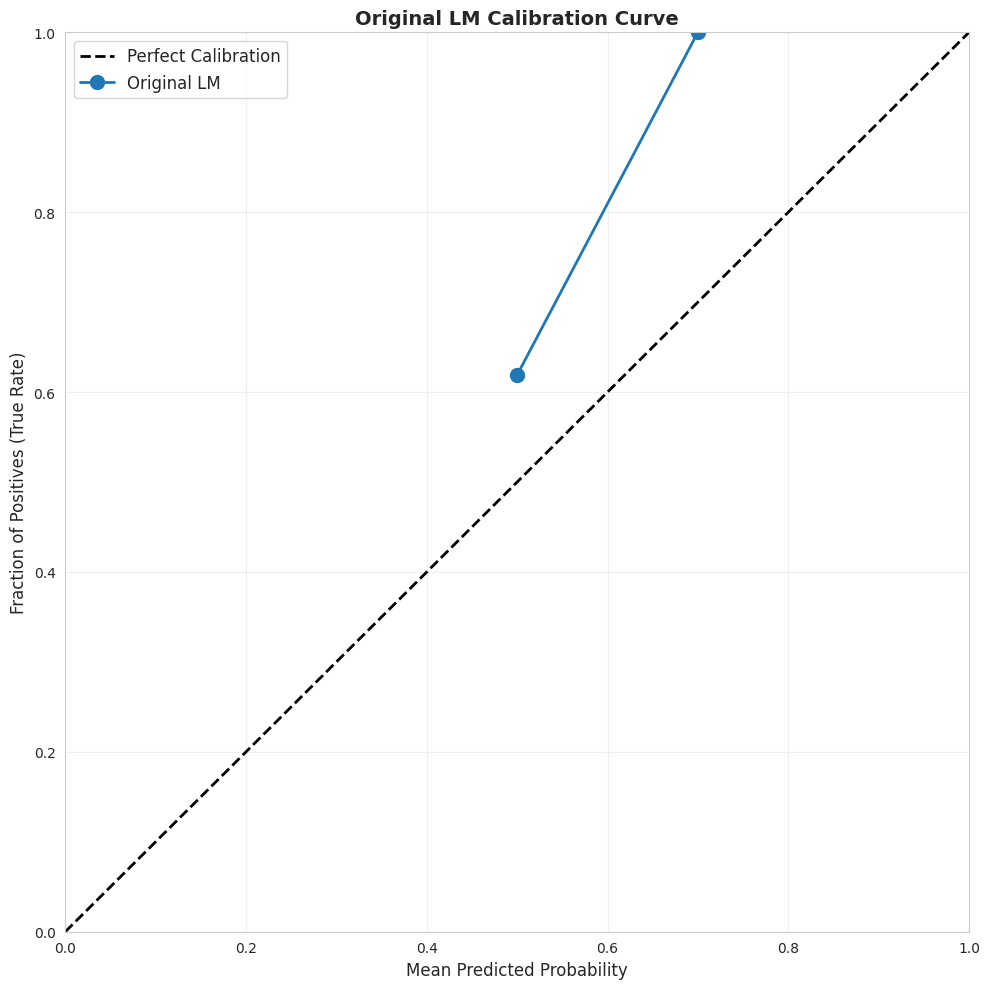

Expected Calibration Error (ECE): 0.2095


In [6]:
confidences = df_labeled['lm_confidence'].values
labels = df_labeled['ground_truth'].values

# Compute calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    labels, confidences, n_bins=10, strategy='uniform'
)

# Plot
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)
plt.plot(mean_predicted_value, fraction_of_positives, 'o-', 
         label='Original LM', markersize=10, linewidth=2)

plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('Fraction of Positives (True Rate)', fontsize=12)
plt.title('Original LM Calibration Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add diagonal reference
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.tight_layout()
plt.savefig('original_calibration_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate ECE
ece = np.abs(mean_predicted_value - fraction_of_positives).mean()
print(f"Expected Calibration Error (ECE): {ece:.4f}")

In [7]:
def brier_score(confidences, labels):
    """Calculate Brier score"""
    return np.mean((confidences - labels) ** 2)

original_brier = brier_score(confidences, labels)

print("="*80)
print("CALIBRATION METRICS - ORIGINAL LM")
print("="*80)
print(f"Brier Score: {original_brier:.4f}")
print(f"  (Lower is better, perfect score = 0.0)")
print(f"\nInterpretation:")
if original_brier < 0.1:
    print("  Excellent calibration")
elif original_brier < 0.2:
    print("  Good calibration")
elif original_brier < 0.3:
    print("  Moderate calibration - improvement needed")
else:
    print("  Poor calibration - significant improvement needed")

CALIBRATION METRICS - ORIGINAL LM
Brier Score: 0.2410
  (Lower is better, perfect score = 0.0)

Interpretation:
  Moderate calibration - improvement needed


In [8]:
with open('calibration_params.json', 'r') as f:
    params = json.load(f)

print("Calibration Parameters:")
print(json.dumps(params, indent=2))

# Apply calibration based on method
def apply_calibration(confidences, method, temperature=1.5, a=1.0, b=0.0):
    """Apply calibration transformation"""
    epsilon = 1e-10
    confidences = np.clip(confidences, epsilon, 1 - epsilon)
    logits = np.log(confidences / (1 - confidences))
    
    if method == 'temperature':
        scaled_logits = logits / temperature
    elif method == 'platt':
        scaled_logits = a * logits + b
    else:
        return confidences
    
    return 1 / (1 + np.exp(-scaled_logits))

# Apply calibration
if params['method'] == 'temperature':
    calibrated_confidences = apply_calibration(
        confidences, 'temperature', temperature=params['temperature']
    )
elif params['method'] == 'platt':
    calibrated_confidences = apply_calibration(
        confidences, 'platt', a=params['platt_a'], b=params['platt_b']
    )

print(f"\n✅ Applied {params['method']} calibration")

Calibration Parameters:
{
  "method": "platt",
  "temperature": 1.0,
  "platt_a": 4.970079134559636,
  "platt_b": 0.48556688454091146
}

✅ Applied platt calibration


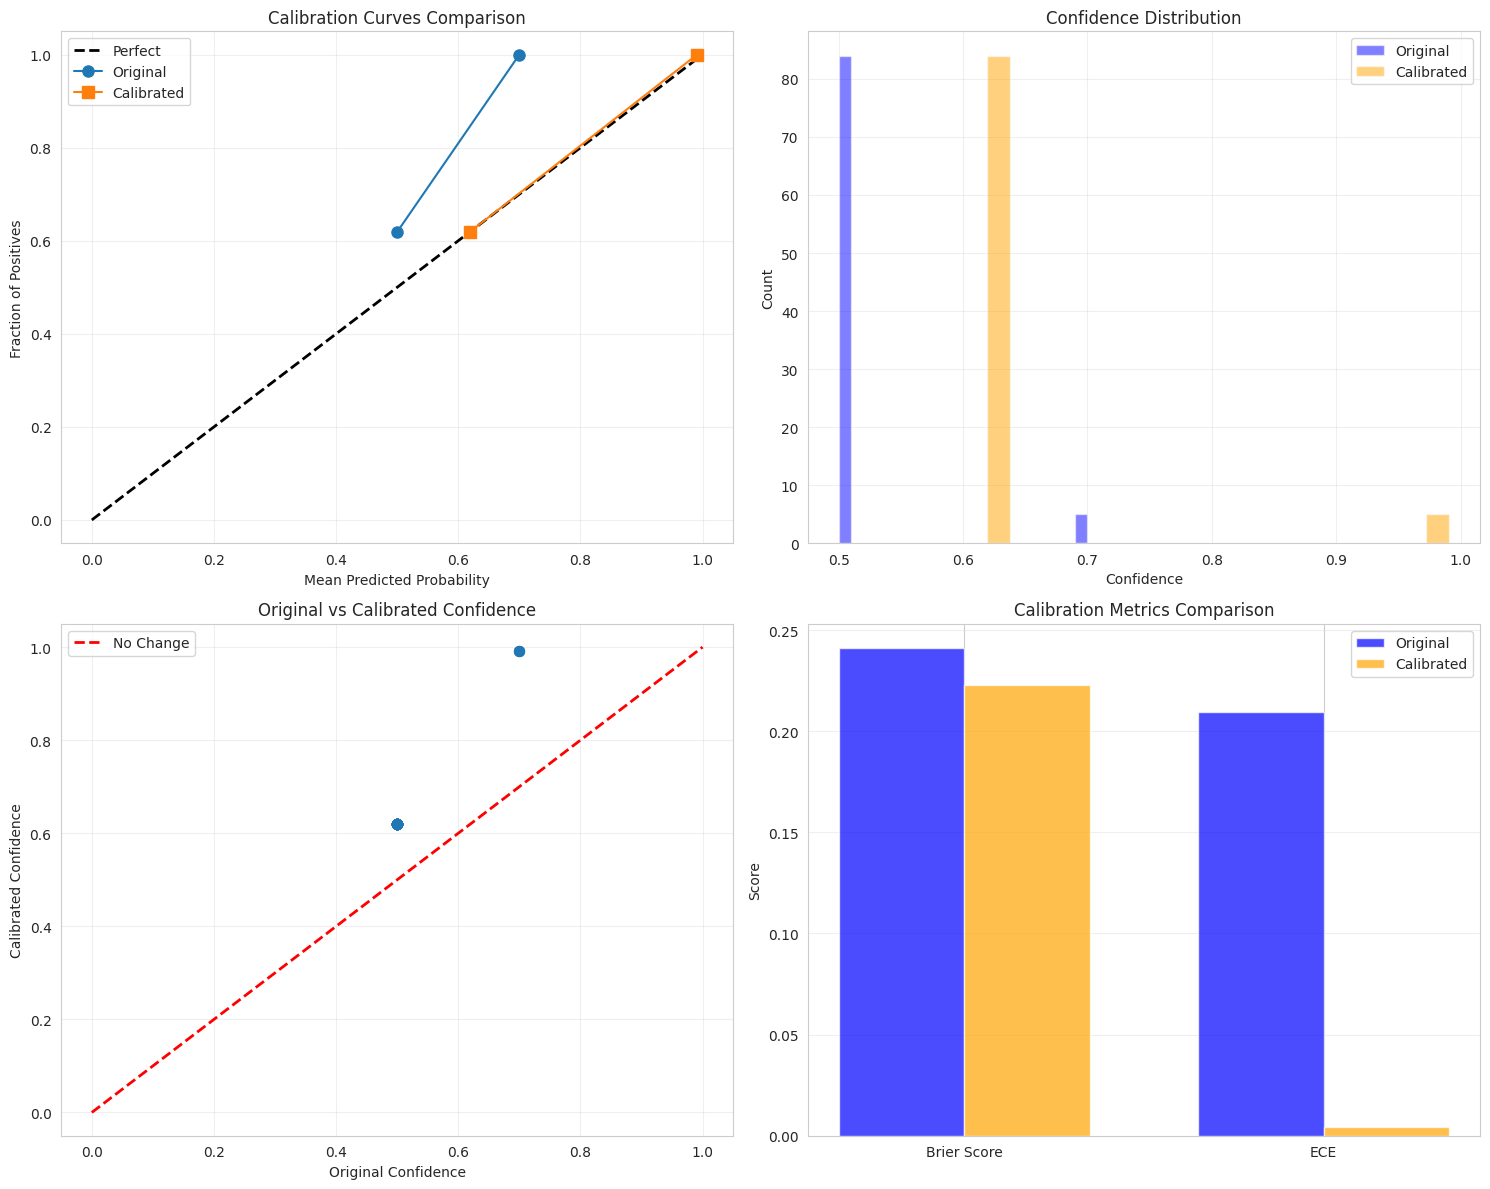

CALIBRATION IMPROVEMENT
Brier Score:
  Original: 0.2410
  Calibrated: 0.2226
  Improvement: +7.6%

Expected Calibration Error:
  Original: 0.2095
  Calibrated: 0.0045
  Improvement: +97.8%


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Calibration curves comparison
fraction_orig, mean_orig = calibration_curve(labels, confidences, n_bins=10)
fraction_cal, mean_cal = calibration_curve(labels, calibrated_confidences, n_bins=10)

axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Perfect', linewidth=2)
axes[0, 0].plot(mean_orig, fraction_orig, 'o-', label='Original', markersize=8)
axes[0, 0].plot(mean_cal, fraction_cal, 's-', label='Calibrated', markersize=8)
axes[0, 0].set_xlabel('Mean Predicted Probability')
axes[0, 0].set_ylabel('Fraction of Positives')
axes[0, 0].set_title('Calibration Curves Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Confidence distributions
axes[0, 1].hist(confidences, bins=20, alpha=0.5, label='Original', color='blue')
axes[0, 1].hist(calibrated_confidences, bins=20, alpha=0.5, label='Calibrated', color='orange')
axes[0, 1].set_xlabel('Confidence')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Confidence Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Scatter plot
axes[1, 0].scatter(confidences, calibrated_confidences, alpha=0.6, s=50)
axes[1, 0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='No Change')
axes[1, 0].set_xlabel('Original Confidence')
axes[1, 0].set_ylabel('Calibrated Confidence')
axes[1, 0].set_title('Original vs Calibrated Confidence')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Metrics comparison
metrics = ['Brier Score', 'ECE']
original_metrics = [
    brier_score(confidences, labels),
    np.abs(mean_orig - fraction_orig).mean()
]
calibrated_metrics = [
    brier_score(calibrated_confidences, labels),
    np.abs(mean_cal - fraction_cal).mean()
]

x = np.arange(len(metrics))
width = 0.35

axes[1, 1].bar(x - width/2, original_metrics, width, label='Original', color='blue', alpha=0.7)
axes[1, 1].bar(x + width/2, calibrated_metrics, width, label='Calibrated', color='orange', alpha=0.7)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Calibration Metrics Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('calibration_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print improvements
print("="*80)
print("CALIBRATION IMPROVEMENT")
print("="*80)
print(f"Brier Score:")
print(f"  Original: {original_metrics[0]:.4f}")
print(f"  Calibrated: {calibrated_metrics[0]:.4f}")
print(f"  Improvement: {((original_metrics[0] - calibrated_metrics[0])/original_metrics[0]*100):+.1f}%")
print(f"\nExpected Calibration Error:")
print(f"  Original: {original_metrics[1]:.4f}")
print(f"  Calibrated: {calibrated_metrics[1]:.4f}")
print(f"  Improvement: {((original_metrics[1] - calibrated_metrics[1])/original_metrics[1]*100):+.1f}%")

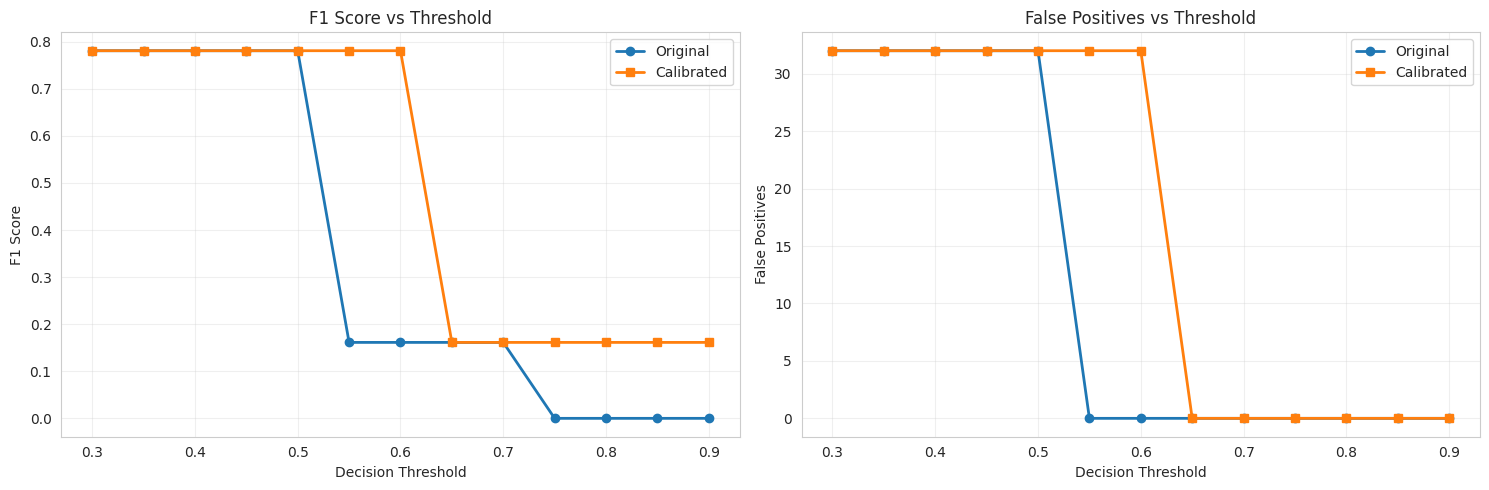

Optimal Thresholds:
  Original: 0.30 (F1: 0.781)
  Calibrated: 0.30 (F1: 0.781)


In [10]:
thresholds = np.arange(0.3, 0.9, 0.05)

original_results = []
calibrated_results = []

for thresh in thresholds:
    # Original
    orig_pred = (confidences >= thresh).astype(int)
    orig_tp = np.sum((orig_pred == 1) & (labels == 1))
    orig_fp = np.sum((orig_pred == 1) & (labels == 0))
    orig_tn = np.sum((orig_pred == 0) & (labels == 0))
    orig_fn = np.sum((orig_pred == 0) & (labels == 1))
    
    orig_precision = orig_tp / (orig_tp + orig_fp) if (orig_tp + orig_fp) > 0 else 0
    orig_recall = orig_tp / (orig_tp + orig_fn) if (orig_tp + orig_fn) > 0 else 0
    orig_f1 = 2 * orig_precision * orig_recall / (orig_precision + orig_recall) if (orig_precision + orig_recall) > 0 else 0
    
    original_results.append({
        'threshold': thresh,
        'precision': orig_precision,
        'recall': orig_recall,
        'f1': orig_f1,
        'fp': orig_fp,
        'fn': orig_fn
    })
    
    # Calibrated
    cal_pred = (calibrated_confidences >= thresh).astype(int)
    cal_tp = np.sum((cal_pred == 1) & (labels == 1))
    cal_fp = np.sum((cal_pred == 1) & (labels == 0))
    cal_tn = np.sum((cal_pred == 0) & (labels == 0))
    cal_fn = np.sum((cal_pred == 0) & (labels == 1))
    
    cal_precision = cal_tp / (cal_tp + cal_fp) if (cal_tp + cal_fp) > 0 else 0
    cal_recall = cal_tp / (cal_tp + cal_fn) if (cal_tp + cal_fn) > 0 else 0
    cal_f1 = 2 * cal_precision * cal_recall / (cal_precision + cal_recall) if (cal_precision + cal_recall) > 0 else 0
    
    calibrated_results.append({
        'threshold': thresh,
        'precision': cal_precision,
        'recall': cal_recall,
        'f1': cal_f1,
        'fp': cal_fp,
        'fn': cal_fn
    })

df_orig = pd.DataFrame(original_results)
df_cal = pd.DataFrame(calibrated_results)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# F1 Score
axes[0].plot(df_orig['threshold'], df_orig['f1'], 'o-', label='Original', linewidth=2)
axes[0].plot(df_cal['threshold'], df_cal['f1'], 's-', label='Calibrated', linewidth=2)
axes[0].set_xlabel('Decision Threshold')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score vs Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# False Positives
axes[1].plot(df_orig['threshold'], df_orig['fp'], 'o-', label='Original', linewidth=2)
axes[1].plot(df_cal['threshold'], df_cal['fp'], 's-', label='Calibrated', linewidth=2)
axes[1].set_xlabel('Decision Threshold')
axes[1].set_ylabel('False Positives')
axes[1].set_title('False Positives vs Threshold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Find optimal threshold
optimal_orig_idx = df_orig['f1'].idxmax()
optimal_cal_idx = df_cal['f1'].idxmax()

print(f"Optimal Thresholds:")
print(f"  Original: {df_orig.loc[optimal_orig_idx, 'threshold']:.2f} (F1: {df_orig.loc[optimal_orig_idx, 'f1']:.3f})")
print(f"  Calibrated: {df_cal.loc[optimal_cal_idx, 'threshold']:.2f} (F1: {df_cal.loc[optimal_cal_idx, 'f1']:.3f})")

In [11]:
report = f"""
{'='*80}
ATELIER A - TRUST AGENT CALIBRATION REPORT
{'='*80}

1. DATASET SUMMARY
   - Total samples: {len(df_labeled)}
   - True Positives: {np.sum(labels == 1)} ({np.mean(labels)*100:.1f}%)
   - False Positives: {np.sum(labels == 0)} ({(1-np.mean(labels))*100:.1f}%)

2. ORIGINAL LM PERFORMANCE
   - Mean confidence: {np.mean(confidences):.3f}
   - Brier Score: {brier_score(confidences, labels):.4f}
   - Expected Calibration Error: {np.abs(mean_orig - fraction_orig).mean():.4f}

3. CALIBRATION METHOD
   - Method: {params['method'].upper()}
   - Parameters: {json.dumps({k:v for k,v in params.items() if k != 'method'}, indent=2)}

4. CALIBRATED PERFORMANCE
   - Mean confidence: {np.mean(calibrated_confidences):.3f}
   - Brier Score: {brier_score(calibrated_confidences, labels):.4f}
   - Expected Calibration Error: {np.abs(mean_cal - fraction_cal).mean():.4f}

5. IMPROVEMENT
   - Brier Score: {((brier_score(confidences, labels) - brier_score(calibrated_confidences, labels))/brier_score(confidences, labels)*100):+.1f}%
   - ECE: {((np.abs(mean_orig - fraction_orig).mean() - np.abs(mean_cal - fraction_cal).mean())/np.abs(mean_orig - fraction_orig).mean()*100):+.1f}%

6. RECOMMENDATIONS
   - Optimal threshold (original): {df_orig.loc[optimal_orig_idx, 'threshold']:.2f}
   - Optimal threshold (calibrated): {df_cal.loc[optimal_cal_idx, 'threshold']:.2f}
   - Reduction in false positives at optimal threshold: {df_orig.loc[optimal_orig_idx, 'fp'] - df_cal.loc[optimal_cal_idx, 'fp']:.0f}

{'='*80}
"""

print(report)

# Save report
with open('calibration_report.txt', 'w') as f:
    f.write(report)

print("\n✅ Report saved to calibration_report.txt")


ATELIER A - TRUST AGENT CALIBRATION REPORT

1. DATASET SUMMARY
   - Total samples: 89
   - True Positives: 57 (64.0%)
   - False Positives: 32 (36.0%)

2. ORIGINAL LM PERFORMANCE
   - Mean confidence: 0.511
   - Brier Score: 0.2410
   - Expected Calibration Error: 0.2095

3. CALIBRATION METHOD
   - Method: PLATT
   - Parameters: {
  "temperature": 1.0,
  "platt_a": 4.970079134559636,
  "platt_b": 0.48556688454091146
}

4. CALIBRATED PERFORMANCE
   - Mean confidence: 0.640
   - Brier Score: 0.2226
   - Expected Calibration Error: 0.0045

5. IMPROVEMENT
   - Brier Score: +7.6%
   - ECE: +97.8%

6. RECOMMENDATIONS
   - Optimal threshold (original): 0.30
   - Optimal threshold (calibrated): 0.30
   - Reduction in false positives at optimal threshold: 0



✅ Report saved to calibration_report.txt


In [12]:
summary_data = {
    'Metric': ['Brier Score', 'ECE', 'Mean Confidence', 'Optimal Threshold'],
    'Original': [
        brier_score(confidences, labels),
        np.abs(mean_orig - fraction_orig).mean(),
        np.mean(confidences),
        df_orig.loc[optimal_orig_idx, 'threshold']
    ],
    'Calibrated': [
        brier_score(calibrated_confidences, labels),
        np.abs(mean_cal - fraction_cal).mean(),
        np.mean(calibrated_confidences),
        df_cal.loc[optimal_cal_idx, 'threshold']
    ]
}

df_summary = pd.DataFrame(summary_data)
df_summary['Improvement (%)'] = ((df_summary['Original'] - df_summary['Calibrated']) / df_summary['Original'] * 100)

print("Summary Table:")
print(df_summary.to_string(index=False))

# Save to CSV
df_summary.to_csv('calibration_summary.csv', index=False)
print("\n✅ Summary saved to calibration_summary.csv")

Summary Table:
           Metric  Original  Calibrated  Improvement (%)
      Brier Score  0.241011    0.222584         7.646001
              ECE  0.209524    0.004528        97.838739
  Mean Confidence  0.511236    0.639955       -25.177926
Optimal Threshold  0.300000    0.300000         0.000000

✅ Summary saved to calibration_summary.csv
